100%|██████████| 170498071/170498071 [00:02<00:00, 61120824.89it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[1,  6400] loss: 2.029
[1, 12800] loss: 1.869
[1, 19200] loss: 1.803
[1, 25600] loss: 1.741
[1, 32000] loss: 1.723
[1, 38400] loss: 1.675
[1, 44800] loss: 1.670
[2,  6400] loss: 1.634
[2, 12800] loss: 1.621
[2, 19200] loss: 1.627
[2, 25600] loss: 1.610
[2, 32000] loss: 1.591
[2, 38400] loss: 1.590
[2, 44800] loss: 1.572
Finished Training


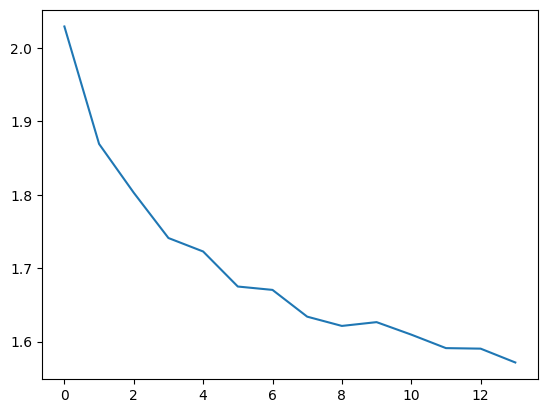

Accuracy of the network on the 10000 test images: 45 %


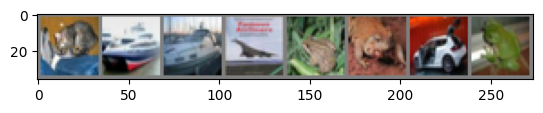

Predicted:    cat truck  ship plane  deer  frog   cat  frog
GroundTruth:    cat  ship  ship plane  frog  frog   car  frog


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(78)

# Load and Normalize the CIFAR-10 Dataset https://www.cs.toronto.edu/~kriz/cifar.html
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define a Linear Neural Network Classifier
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 10)

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = self.fc1(x)
        return x

# Define a Non-linear Fully-Connected Neural Network with Dropout
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 120)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define a Convolutional Neural Network
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*  8*  8, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8*  8*  8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model = Net2() # Try also "model = Net1()" and "model = Net3()"

criterion = nn.CrossEntropyLoss() # combines softmax layer with the cross-entropy loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

loss_values = []  # List to store loss values

# Train the Network
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        outputs = model(inputs)
        loss = criterion(outputs, labels) # combines softmax layer with the cross-entropy loss function

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, (i + 1) * 64, running_loss / 100))
            loss_values.append(running_loss / 100)  # Store averaged loss value
            running_loss = 0.0
    torch.save(model.state_dict(), f"checkpoint_{epoch}.pt")

print('Finished Training')

# Plot the training loss
plt.plot(loss_values, label='Training Loss')
plt.show()

# Test the Network on the Test Data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# Show Test Images with Predictions
dataiter = iter(testloader)
images, labels = next(dataiter)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Function to Show Images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(8)))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))


======== Loading model from Epoch 0 checkpoint =============
Accuracy of the network on the 10000 test images: 42 %


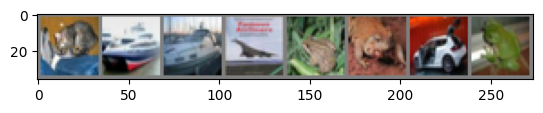

Predicted:    cat  ship  ship  ship  deer  frog   cat  deer
GroundTruth:    cat  ship  ship plane  frog  frog   car  frog


In [2]:
print("======== Loading model from Epoch 0 checkpoint =============")
model.load_state_dict(torch.load( f"checkpoint_0.pt"))

# Test the Network on the Test Data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# Show Test Images with Predictions
dataiter = iter(testloader)
images, labels = next(dataiter)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(8)))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models.resnet import resnet18

# Transformations for the input data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define a Simple ResNet Model
model = resnet18(num_classes=10)

if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Learning rate schedule
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = 0.1 * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Training the model
#for epoch in range(200):  # loop over the dataset multiple times
for epoch in range(200):  # loop over the dataset multiple times

    adjust_learning_rate(optimizer, epoch)
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

# Testing the model
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


Files already downloaded and verified
Files already downloaded and verified
[1,   200] loss: 2.644
[2,   200] loss: 1.607
[3,   200] loss: 1.408
[4,   200] loss: 1.241
[5,   200] loss: 1.114
[6,   200] loss: 1.060
[7,   200] loss: 0.977
[8,   200] loss: 0.925
[9,   200] loss: 0.878
[10,   200] loss: 0.861
[11,   200] loss: 0.834
[12,   200] loss: 0.813
[13,   200] loss: 0.791
[14,   200] loss: 0.774
[15,   200] loss: 0.765
[16,   200] loss: 0.765
[17,   200] loss: 0.754
[18,   200] loss: 0.748
[19,   200] loss: 0.741
[20,   200] loss: 0.729
[21,   200] loss: 0.729
[22,   200] loss: 0.709
[23,   200] loss: 0.708
[24,   200] loss: 0.712
[25,   200] loss: 0.713
[26,   200] loss: 0.705
[27,   200] loss: 0.697
[28,   200] loss: 0.700
[29,   200] loss: 0.670
[30,   200] loss: 0.678
[31,   200] loss: 0.536
[32,   200] loss: 0.443
[33,   200] loss: 0.413
[34,   200] loss: 0.388
[35,   200] loss: 0.390
[36,   200] loss: 0.373
[37,   200] loss: 0.366
[38,   200] loss: 0.353
[39,   200] loss: 0.3